In [1]:
# Libraries
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

# Constants
random.seed(0)
np.random.default_rng()
tf = 60
dt = 0.01
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]
D = 0.0001

def solver(k1, k2, k3, k4, Ac, xi, c0, D):
    """Solves the SDE system for the given parameters.

    Args:
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant
        c0 (array): initial conditions
        D (float): noise constant

    Returns:
        The solution of the system.
    """
    
    x = np.empty(N)
    y = np.empty(N)
    
    eta = np.random.normal(0, 1, N)
    
    x[0] = c0[0]
    y[0] = c0[1]
    
    for j in range(N-1):
        k1x = -k1*x[j] - k2*y[j] + Ac
        k1y = k3*x[j] - k4*y[j] + xi*Ac
        ax = x[j] + k1x*dt
        ax = ax + np.sqrt(2*D*dt)*eta[j]
        ay = y[j] + k1y*dt
        k2x = - k1*ax - k2*ay + Ac
        k2y = k3*ax - k4*ay + xi*Ac
        x[j+1] = x[j] + (k1x+k2x)*dt/2
        x[j+1] = x[j+1] + np.sqrt(2*D*dt)*eta[j]
        y[j+1] = y[j] + (k1y+k2y)*dt/2
    
    return x, y


In [2]:
def get_params_NFBL(initial_parameters, num_params):
    """Get the parameters for the NFBL model.
    Args:
        initial_parameters (array): list of initial parameters for NFBL
        num_params (float): number of parameters to generate
    
    Returns:
    k1: float
    k2_vals: array of floats
    k3_vals: array of floats
    k4: float
    """
    k1 = initial_parameters[0]
    k2 = initial_parameters[1]
    k3 = initial_parameters[2]
    k4 = initial_parameters[3]
    
    C = k1*k4 + k2*k3
    k2_vals = np.random.uniform(0, 3, num_params)
    k3_vals = (C - k1*k4)/k2_vals
    
    if not (all(i >= 0 for i in k2_vals) and all(i >= 0 for i in k3_vals)):
        print(initial_parameters)
        raise ValueError("All generated values must be non-negative.")
    
    return k1, k2_vals, k3_vals, k4

def get_params_IFFL(initial_parameters, num_params):
    """Get the parameters for the IFFL model.
    Args:
        initial_parameters (array): list of initial parameters for NFBL
        num_params (float): number of parameters to generate
    
    Returns:
    K1: float
    K2_vals: array of floats
    K3: float
    K4: float
    xi_vals: array of floats
    """
    
    k1 = initial_parameters[0]
    k2 = initial_parameters[1]
    k3 = initial_parameters[2]
    k4 = initial_parameters[3]
    
    # Since the initial params were constructed for NFBL
    # See curves.ipynb
    B = k1 + k4
    C = k1*k4 + k2*k3
    Q = k4
    
    if B**2 - 4*C < 0:
        print(initial_parameters)
        raise ValueError("Invalid parameters for square root in calculation of K4")
    
    K4 = (-B + np.sqrt(B**2 - 4*C)) / (-2)
    K1 = B - K4
    K3 = 0

    K2_vals = np.random.uniform(0, 3, num_params)
    xi_vals = (K4-Q)/K2_vals
    
    if K4 < 0 or K1 < 0:
        print(initial_parameters)
        raise ValueError("Invalid parameters for K1 or K4")
    
    if not (all(i >= 0 for i in K2_vals) and all(i >= 0 for i in xi_vals)):
        print(initial_parameters)
        raise ValueError("All generated values must be non-negative.")
    
    return K1, K2_vals, K3, K4, xi_vals

In [3]:
initial_nfbl_parameters = np.array([[1, 2, 0.05, 0.05, 1, 0], [2, 2, 0.05, 0.05, 1, 0], [2, 2, 0.1, 0.05, 1, 0], [1, 1, 0.1, 0.05, 1, 0], 
                                    [0.5, 0.5, 0.1, 0.05, 1, 0], [1, 1, 0.1, 0.1, 1, 0], [1, 2, 0.1, 0.05, 1, 0], [1, 1.25, 0.1, 0.1, 1, 0], 
                                    [3, 1, 0.1, 0.05, 1, 0], [0.75, 1.15, 0.05, 0.1, 1, 0], [1, 2.25, 0.05, 0.1, 1, 0], [1, 0.5, 0.2, 0.1, 1, 0], 
                                    [0.75, 0.2, 0.5, 0.1, 1, 0], [1.25, 0.25, 0.25, 0.15, 1, 0], [0.8, 3, 0.01, 0.05, 1, 0], [0.65, 1, 0.05, 0.1, 1, 0],
                                    [2, 1, 0.1, 0.1, 1, 0], [0.5, 2, 0.01, 0.01, 1, 0], [0.3, 2, 0.01, 0.01, 1, 0], [0.5, 1, 0.05, 0.01, 1, 0],
                                    [0.55, 1.25, 0.05, 0.01, 1, 0], [0.75, 2, 0.05, 0.01, 1, 0], [0.35, 1.5, 0.01, 0.05, 1, 0], [0.25, 0.35, 0.025, 0.05, 1, 0],
                                    [0.3875, 0.55, 0.03, 0.05, 1, 0]])

In [4]:
def all_elements_different_2d(arr):
    return len(arr) == len(set(map(tuple, arr)))

from collections import Counter
def find_duplicates(arr):
    counter = Counter(map(tuple, arr))
    return [item for item in counter.items() if item[1] > 1]

print(all_elements_different_2d(initial_nfbl_parameters))  # Returns True if all elements are different
print(find_duplicates(initial_nfbl_parameters))

True
[]


# NFBL

In [5]:
# xi = 0
# We have 50000 curves in total, 25000 for NFBL and 25000 for IFFL
# We need 25 different curves, so 1000 curves for each, 25 different B, C, Q values
total_curves = 50000
num_curves = int(total_curves/2)
different_curves = 25
num_params = int(num_curves/different_curves)

Ac = 1
xi = 0

t = np.arange(0, tf, dt)
t_shape = np.shape(t)[0]

x = np.empty([num_curves, t_shape])
y = np.empty([num_curves, t_shape])

for i in tqdm(range(different_curves)):
    k1, k2_vals, k3_vals, k4 = get_params_NFBL(initial_nfbl_parameters[i], num_params)
    for j in range(num_params):
        sol = solver(k1, k2_vals[j], k3_vals[j], k4, Ac, xi, c0, D)
        x[i*num_params+j] = sol[0]
        y[i*num_params+j] = sol[1]

100%|██████████| 25/25 [10:29<00:00, 25.20s/it]


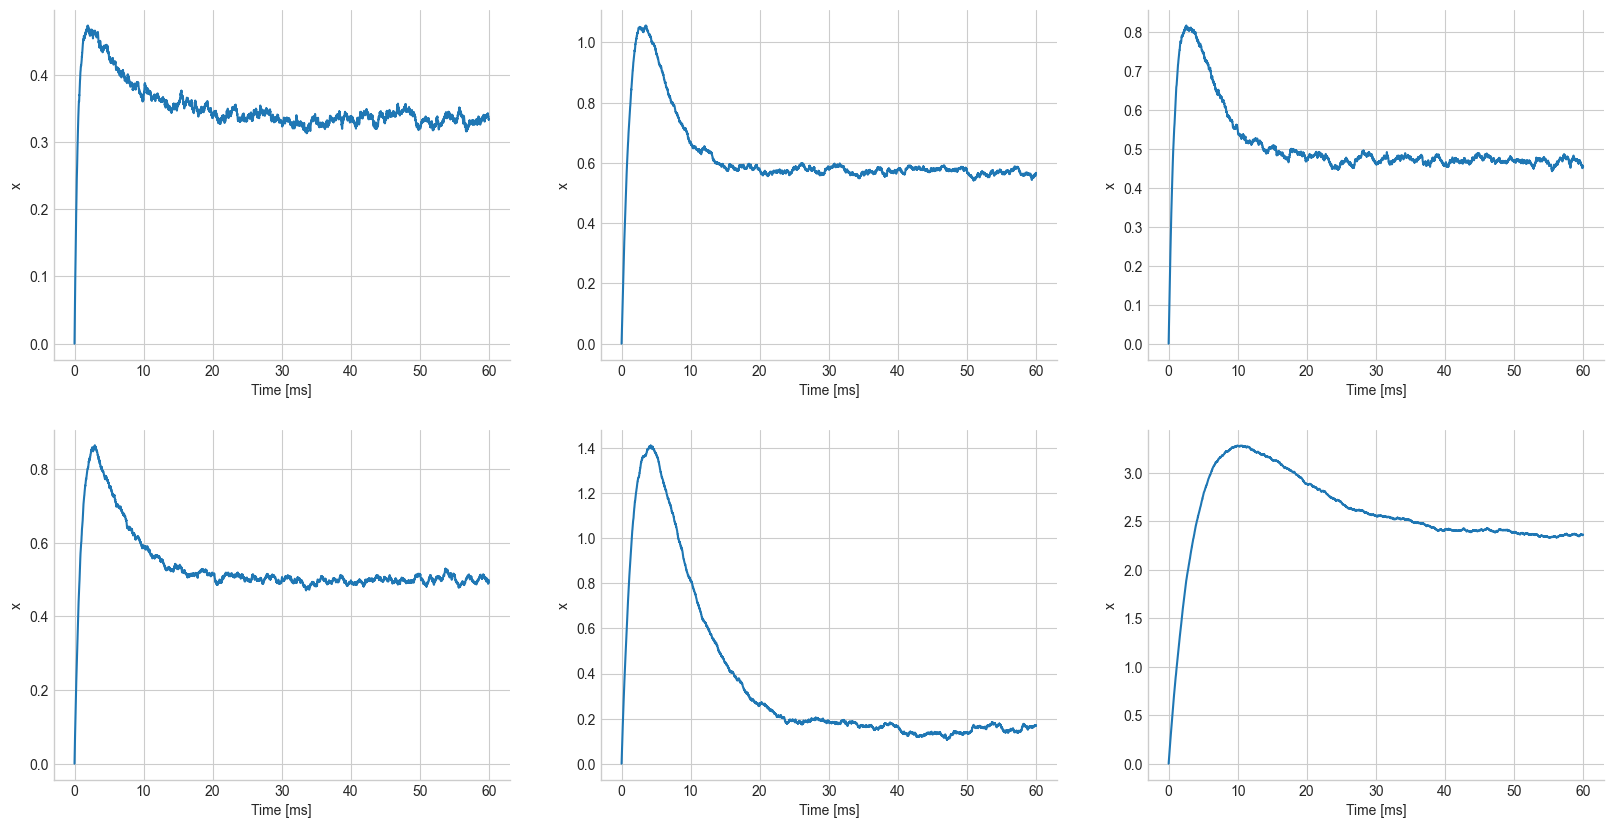

In [6]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    random_index = np.random.choice(len(x))
    ax[i//3, i%3].plot(t, x[random_index])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

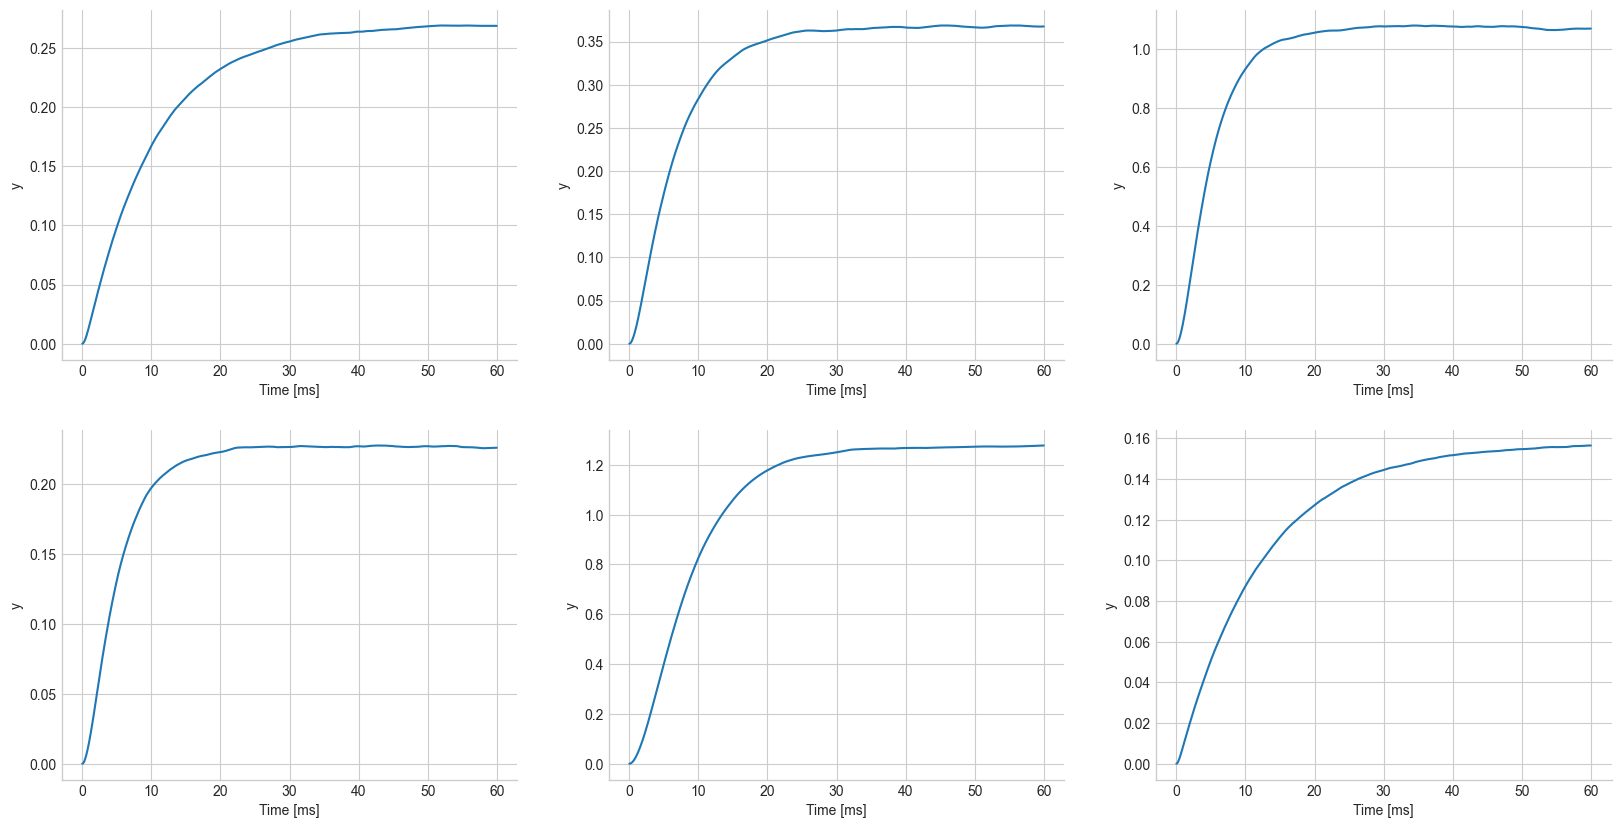

In [7]:
# Plot Y
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    random_index = np.random.choice(len(x))
    ax[i//3, i%3].plot(t, y[random_index])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('y')

In [8]:
t_min = 10
t_max = 50
t_vals = np.random.randint(t_min, t_max, num_curves)

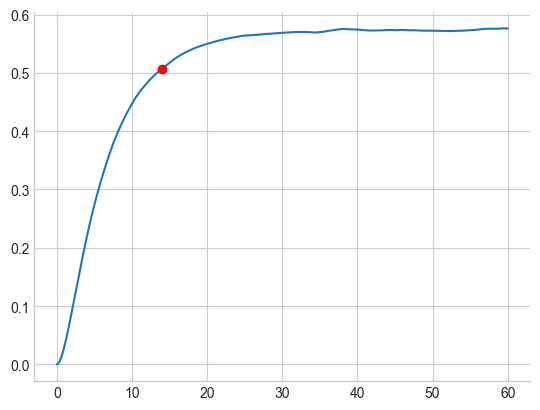

In [9]:
t_correction = int(1/dt)

plt.plot(t, y[10])
plt.plot(t_vals[10], y[10][t_vals[10]*t_correction], 'ro')

In [10]:
data = np.empty([num_curves*2, tf+2]) # +2 since we need to add t and y(t)

indices = np.arange(tf) * t_correction

for i in range(num_curves):
    data[i, 0] = t_vals[i]
    data[i, 1] = y[i][t_vals[i]*t_correction]
    data[i, 2:] = x[i][indices]

# IFFL

In [11]:
# K3 = 0

x = np.empty([num_curves, t_shape])
y = np.empty([num_curves, t_shape])

for i in tqdm(range(different_curves)):
    K1, K2_vals, K3, K4, xi_vals = get_params_IFFL(initial_nfbl_parameters[i], num_params)
    for j in range(num_params):
        sol = solver(K1, K2_vals[j], K3, K4, Ac, xi_vals[j], c0, D)
        x[i*num_params+j] = sol[0]
        y[i*num_params+j] = sol[1]

100%|██████████| 25/25 [10:52<00:00, 26.12s/it]


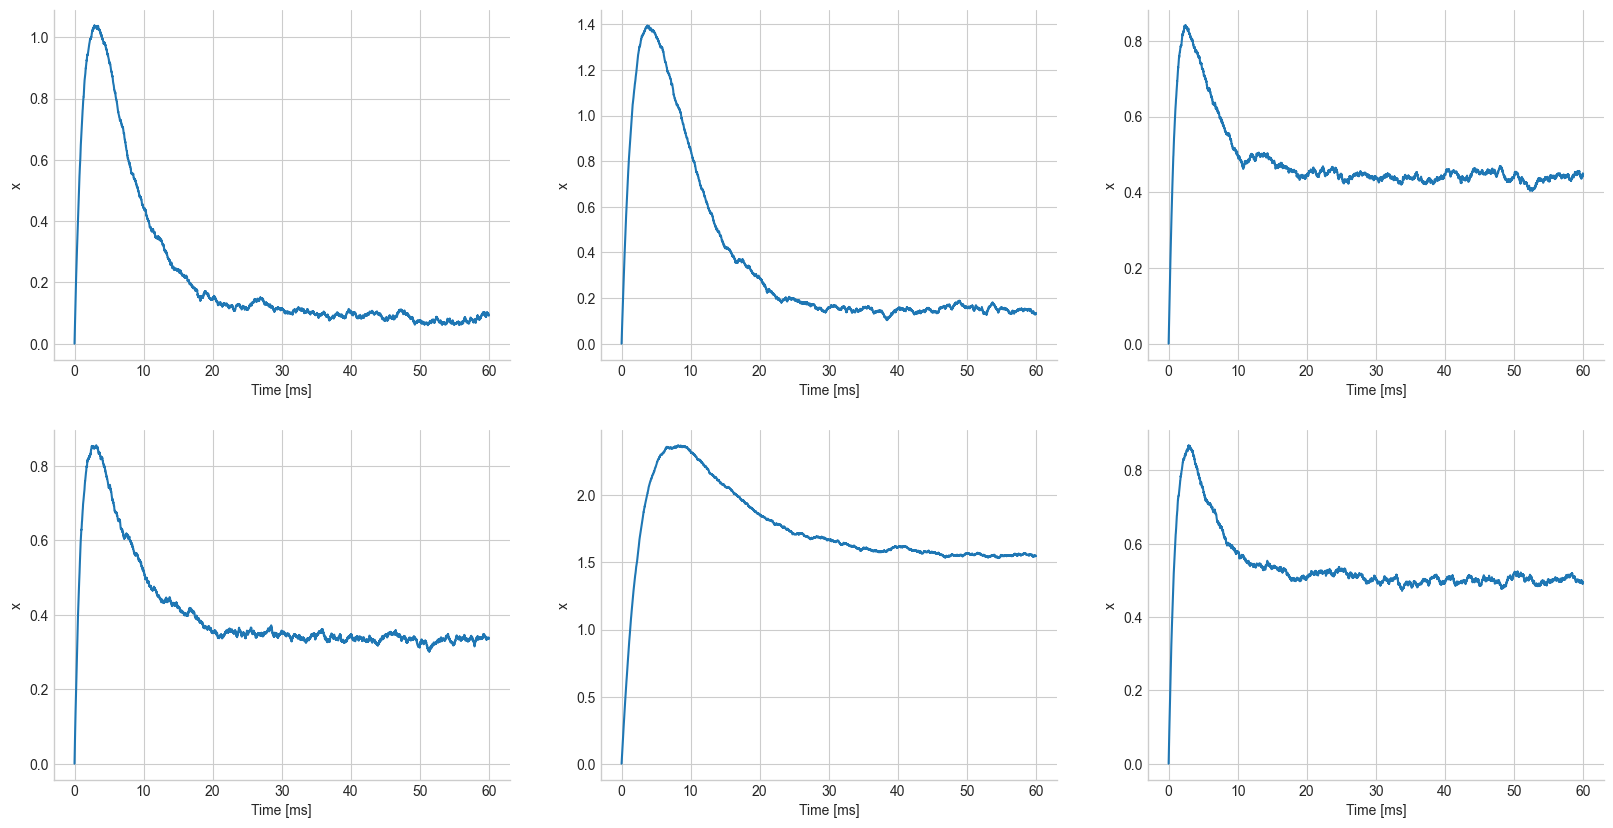

In [13]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    random_index = np.random.choice(len(x))
    ax[i//3, i%3].plot(t, x[random_index])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

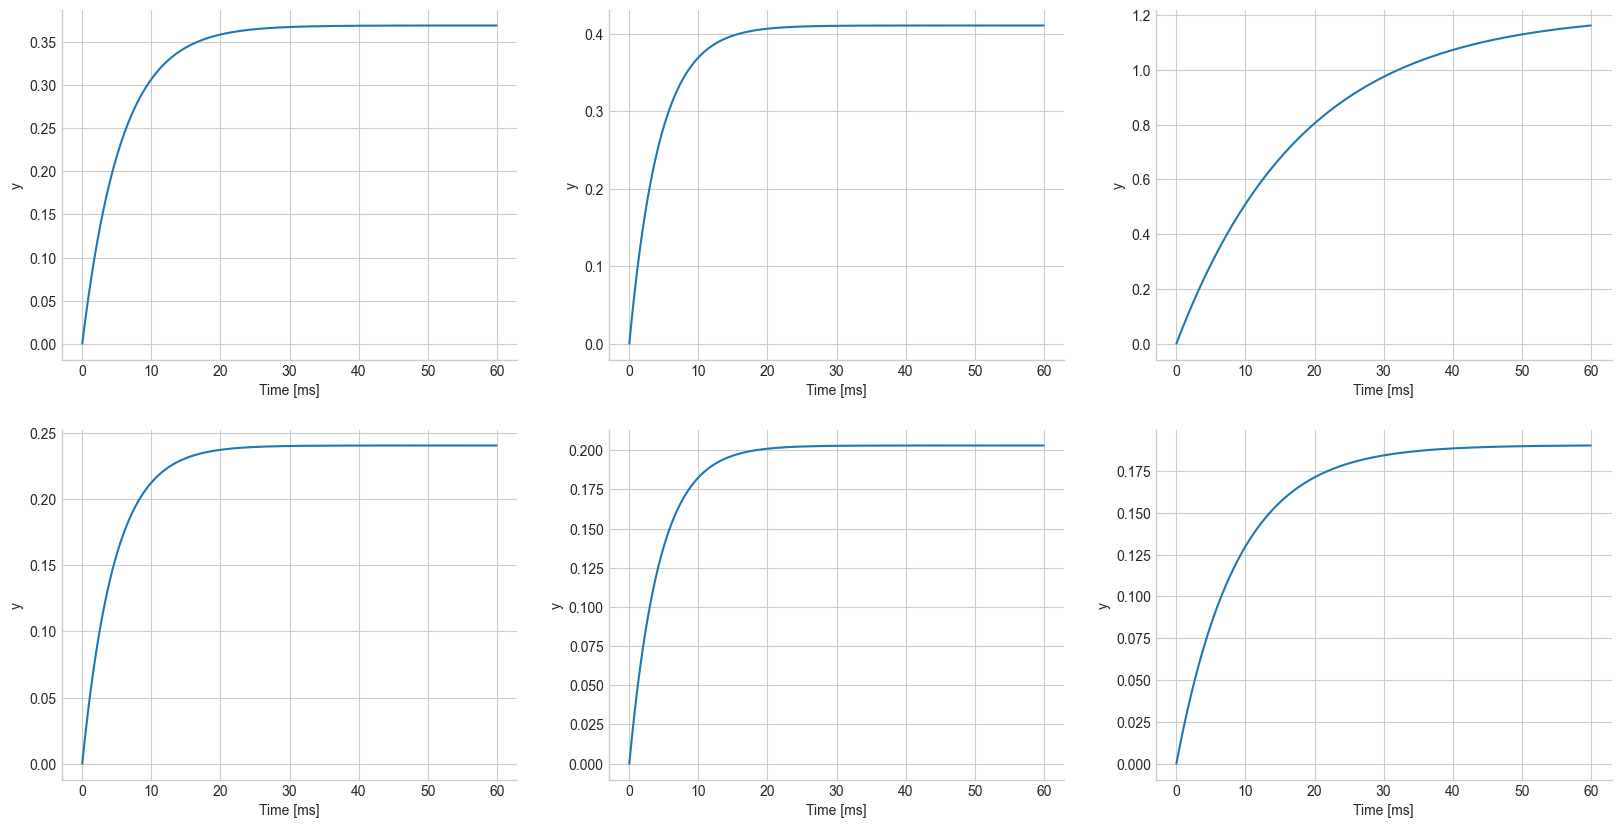

In [14]:
# Plot Y
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    random_index = np.random.choice(len(x))
    ax[i//3, i%3].plot(t, y[random_index])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('y')

In [15]:
for i in range(num_curves):
    data[num_curves+i, 0] = t_vals[i]
    data[num_curves+i, 1] = y[i][t_vals[i]*t_correction]
    data[num_curves+i, 2:] = x[i][indices]

In [16]:
# Create the labels array
# 1 NFBL, 0 IFFL
labels = np.empty(total_curves)
labels[:num_curves] = 1
labels[num_curves:] = 0

In [17]:
# Save the data
np.savetxt("data_dif_curves_noise.csv", data, delimiter=",")
np.savetxt("labels.csv", labels, delimiter=",")